<h1>Preprocessing for the vehcle data at the University of Bath</h1>

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

<h2>Read multipe files and cleaning data</h2>

In [5]:
# read multiple files
os.chdir('/Users/Shared/csv_data_2022')
df_dict ={}
for num in glob.glob("*"):
    df_dict[num] = pd.read_csv(num, low_memory = False, encoding ='utf-8')
    
# Modify the header names        
    c_names = df_dict[num].columns.values
    for i in range(len(c_names)):
        c_names[i] = c_names[i].strip()
        c_names[i] = c_names[i].title()
    
    df_dict[num].columns = c_names
    df_dict[num]["Source file"] = num
         
   #Date
    for x in ("Data", "6"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x : 'Date'})
    
    #Time
    if 'Time ( In Am)' in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={'Time ( In Am)' : 'Time'})
    
    #Type of vehicle            
    for x in ("Category","Type Of Vehicle","Category Of Vehicle", "Vehicle Type"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x : 'Type'})
    
    #Ocupancy
    for x in ("Occupancy(Percentage)", "Occupancy Of The Vehicle"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: 'Occupancy'})
    if 'Capacity' in df_dict[num].columns:
        df_dict[num]["Occupancy"] = df_dict[num]["Occupancy"]*df_dict[num]["Capacity"]
    
    #Direction
    for x in ("Direction Of Vehicle", "Direction Of Travel"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: 'Direction'})
    
    #Driver's Gender
    for x in ("Driver'S Gender", "Gender Of The Driver", "Gender Of Driver", "Gender", "Bus Driver Gender","Driver‘S Gender", "Driver Gender"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: "Driver's gender"})
    
    #EV
    for x in ('Electric Or Not', 'Cartype', 'Electric / Non-Electric Vehicle', 'Electric','Engine Type', 'Electric Or Hybrid?', 'Engine', 
              'Electric_Vehicle', "Fuel", " Electric_Vehicle", "Eco-Friendly", "Not_Petrol"):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: 'Electric Vehicle'})
            
    #Colour
    for x in ('Colour Of Vehicle', 'Vehicle Colour'):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: 'Colour'})
    
    #Brand
    for x in ('Car Company/Bus No', 'Vehicle Brand', 'Vehicle Brand'):
        if x in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={x: 'Brand'})
    
    #Public or private
    for x in ('Public Transport', 'Transport Type (Public/Private)', 'Type Of Transportation', 'Transportation Type'):
        if x in df_dict[num].columns:
            df_dict[num][x] = df_dict[num][x].str.lower()
            df_dict[num][x] = df_dict[num][x].replace('private', True).replace('no', True)
            df_dict[num][x] = df_dict[num][x].replace('public', False).replace('yes', False)
            df_dict[num] = df_dict[num].rename(columns={x: 'Private'})
    if 'Personal' in df_dict[num].columns: df_dict[num] = df_dict[num].rename(columns={'Personal' : 'Private'})
            
#Merge the dictionary of data
df_combined = pd.concat(df_dict)
df_combined = df_combined.reindex(columns=['Source file', 'Date', 'Time', 'Direction', 'Type', 'Occupancy', 'Private'])

#Delete columns and raws all which data is Nan
index_nan = np.where(df_combined["Direction"].isna())[0]
df_combined = df_combined.drop(df_combined.index[index_nan])
df_combined.dropna(how="all",inplace=True)
df_combined.dropna(axis=1,how="all",inplace=True)

#remove the data of afternoon
df_combined = df_combined[~df_combined['Time'].str.contains('pm')]

#Make all data of date the same format(e.g. 2022-10-27)
df_combined.loc[df_combined['Date'] == '27-Oct', ['Date']]='27-10-2022'
df_combined['Date'] = pd.to_datetime(df_combined['Date'], dayfirst = True)

#reset index
df_combined = df_combined.reset_index(drop=True)

#Make all data the same format
#remove space and %, and convert lower character
df_combined['Time'] = df_combined['Time'].str.strip()
df_combined['Direction'] = df_combined['Direction'].str.strip()
df_combined['Direction'] = df_combined['Direction'].str.lower()
df_combined['Type'] = df_combined['Type'].str.strip()
df_combined['Type'] = df_combined['Type'].str.lower()
df_combined['Occupancy'] = df_combined['Occupancy'].astype('str')
df_combined['Occupancy'] = df_combined['Occupancy'].str.lower()
df_combined['Occupancy'] = df_combined['Occupancy'].str.strip()

#remove am, AM from Time
df_combined['Time'] = df_combined['Time'].str.strip('am')
df_combined['Time'] = df_combined['Time'].str.strip('AM')

# replace a mark (") in columns "Direction" to the data above
df_combined['Direction'] = df_combined['Direction'].replace('"', np.nan)
df_combined['Direction'] = df_combined['Direction'].fillna(method = 'ffill')
df_combined['Time'] = df_combined['Time'].replace('"', np.nan)
df_combined['Time'] = df_combined['Time'].fillna(method = 'ffill')

#Make data of Time the same format (e.g. 09:10, 10:35)
df_combined['Time'] = df_combined['Time'].str.replace('.', ':', regex=True)
df_combined['Time'] = pd.to_datetime(df_combined['Time'])
df_combined['Time'] = df_combined['Time'].dt.round('5min')
df_combined['Time'] = df_combined['Time'].dt.time


#remove % from Occupancy data
df_combined['Occupancy'] = df_combined['Occupancy'].str.strip('%')

for i in range(len(df_combined['Type'])):
    #convert the Type name to a same format
    if "scooter" in df_combined.at[i, 'Type'] and df_combined.at[i, 'Type'] != "scooter":
        df_combined.at[i, 'Type'] = "scooter"
    elif ("bike" in df_combined.at[i, 'Type'] and df_combined.at[i, 'Type'] != "motorbike") or "motorcycle" in df_combined.at[i, 'Type']:
        df_combined.at[i, 'Type'] = "motorbike"
    if "car" in df_combined.at[i, 'Type'] and df_combined.at[i, 'Type'] != "car":
        df_combined.at[i, 'Type'] = "car"
    
    
    #Occupancy(e.g. 1, 40, 80)
    occupancy = df_combined.at[i, 'Occupancy']
    if "empty" in occupancy: occupancy = '1' # only bus driver
    elif "half-full" in occupancy or "medium" in occupancy:
        occupancy = '40' # half of 80 people
    if df_combined.at[i,  'Type'] == "bus":
        occupancy = str(float(occupancy)*0.8) # maximum of bus is 80　people
    if int(float(occupancy)) > 10 and df_combined.at[i, 'Type'] != "bus":
        if df_combined.at[i,  'Type'] == "car" or df_combined.at[i,  'Type'] == 'taxi': occupancy = str(float(occupancy)*0.05) # maximum people in car and taxi is 5　
        elif df_combined.at[i,  'Type'] == "van": occupancy = str(float(occupancy)*0.06) # maximum people in van is 6　
        elif df_combined.at[i,  'Type'] == "lorry" or df_combined.at[i,  'Type'] == "truck": occupancy = str(float(occupancy)*0.02) # maximum people in lorry and truck is 2
        elif df_combined.at[i,  'Type'] == "motorbike": occupancy = 1 #maximum people in motorbike is 1
    occupancy = round(float(occupancy))
    
    #Including Driver
    if occupancy == 0: occupancy =1 
    df_combined.at[i, 'Occupancy'] = occupancy

#reset index by date and time
df_combined = df_combined.sort_values(['Date', 'Time'])
df_combined = df_combined.reset_index(drop=True)

#convert to csvfile
df_combined.to_csv('/Users/Shared/combined_data.csv')

print('combined_data.csv:\n', df_combined)

combined_data.csv:
        Source file       Date      Time Direction   Type Occupancy Private
0     22351457.csv 2022-10-24  10:20:00       out    car         1     NaN
1     22351457.csv 2022-10-24  10:20:00       out    bus         8     NaN
2     22351457.csv 2022-10-24  10:20:00       out    car         1     NaN
3     22351457.csv 2022-10-24  10:20:00       out  lorry         1     NaN
4     22351457.csv 2022-10-24  10:20:00       out    car         2     NaN
...            ...        ...       ...       ...    ...       ...     ...
4352  22351444.csv 2025-10-22  10:55:00       out    car         1     NaN
4353  22351444.csv 2025-10-22  10:55:00       out    car         3     NaN
4354  22351444.csv 2025-10-22  10:55:00       out    car         4     NaN
4355  22351444.csv 2025-10-22  10:55:00       out    car         3     NaN
4356  22351444.csv 2025-10-22  10:55:00       out    car         1     NaN

[4357 rows x 7 columns]


<h2>Refill the Nan values of "Private" column</h2>

Dataset removed rows whch data of "Private" is Nan
           Source file       Date      Time Direction Occupancy Private
Type                                                                  
car      22351492.csv 2022-10-25  10:40:00        in         2    True
car      22351492.csv 2022-10-25  10:40:00        in         2    True
van      22351492.csv 2022-10-25  10:40:00        in         1   False
bicycle  22351492.csv 2022-10-25  10:40:00        in         1    True
tractor  22351492.csv 2022-10-25  10:40:00        in         1   False
...               ...        ...       ...       ...       ...     ...
car      22351498.csv 2022-10-26  11:00:00       out         2    True
car      22351498.csv 2022-10-26  11:00:00       out         5    True
car      22351498.csv 2022-10-26  11:00:00       out         1    True
taxi     22351498.csv 2022-10-26  11:05:00       out         2   False
van      22351498.csv 2022-10-26  11:05:00       out         2    True

[550 rows x 6 columns]



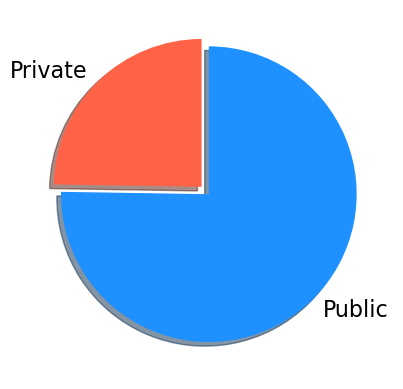

In [64]:
#Caluculate the mean of "Private"　per "Type"
cols = ['Type', 'Private']
df_notnan = df_combined.dropna(subset=['Private'])
df_notnan = df_notnan.set_index(['Type'])
print('Dataset removed rows whch data of "Private" is Nan\n',df_notnan)
print()

types = ["bicycle",  "bus", "car", "lorry", "motorbike", "scooter","taxi", "truck", "van"]
for x in types:
    mean_pr = df_notnan['Private'].groupby(by = ['Type']).mean()
print('Mean of "Private"　per "Type":\n', ratio)
print()

#Refill the Nan values of "Private" 
df_refill = df_combined
for i in range(len(df_refill["Private"])):
    if np.isnan(df_refill.at[i, 'Private']):
        for x in types:
            if df_refill.at[i,'Type'] == x:
                df_refill.at[i, 'Private'] = ratio[x]
                
#removed the rows which Private data are Nan after refilling
df_refill = df_refill.dropna(subset = ['Private'])

#Save as csv
df_refill.to_csv('/Users/Shared/refill_data.csv')

print('refill_data.csv\n',df_refill)
print('Nan value in refill_data.csv:\n',df_refill.isnull().sum())
print()

#Caluculate the number of people per Private or Public by Private*Occupancy
df_refillsum = df_refill.set_index(['Private'])
df_refillsum = df_refillsum['Occupancy'].groupby(level=['Private']).sum()
df_refillsum = df_refillsum.reset_index()
df_refillsum["People"] = df_refillsum['Private']*df_refillsum['Occupancy']
print('Dataset including the number of people per Private or Public\n',df_refillsum)
print()

#Caluculate the ratio of private and ratio of public by the number of people
ratio_private = df_refillsum["People"].sum() / df_refillsum["Occupancy"].sum()
ratio_public = 1- ratio_private
print('The rate of private:', '{:.2%}'.format(ratio_private))
print('The rate of public:', '{:.2%}'.format(ratio_public))

#VIsualization
ratio_pp = np.array([ratio_public,ratio_private])
label = ["Public", "Private"]
color = ["dodgerblue", "tomato"]
explode = [0,0.07]
plt.rcParams['font.size'] = 16.0
plt.pie(ratio_pp, counterclock=False, startangle=90, colors = color, labels = label, shadow = True, explode = explode)
fig = plt.gcf()
fig.savefig("img.png",transparent=True)
plt.show()

In [69]:
#Find the ratio of occupancy of bus which came into university
df_bus = df_combined[df_combined['Type'] == 'bus']
df_busin = df_bus[df_bus['Direction'] == 'in']
mean_busin = df_busin['Occupancy'].mean(axis = 0)
ratio_busin = round(mean_busin *1.25) # convert to rate (*100/80)
print('the ratio of occupancy of bus which came into university:', ratio_busin, '%')

the ratio of occupancy of bus which came into university: 62 %


Driving Licence holders by age in UK[%]


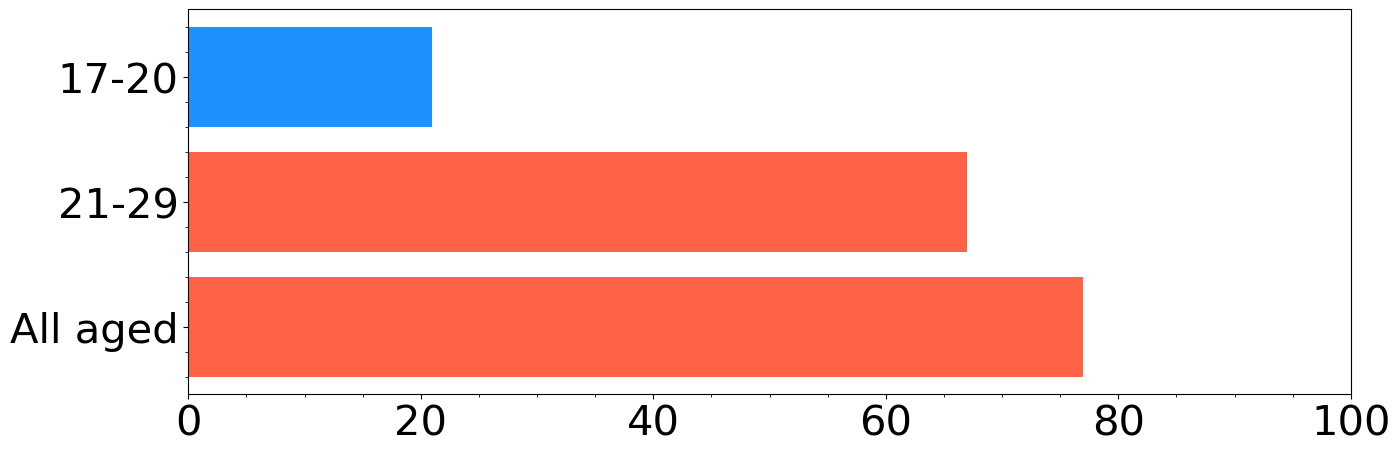

In [71]:
#Visualize the data from additional source 
#(https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/729345/nts0201.ods)
print('Driving Licence holders by age in UK[%]')
X = np.array([77,67,21])
Y = np.array(['All aged','21-29','17-20'])

fig, ax = plt.subplots(figsize = (15, 5))
colors = ["tomato", "tomato", "dodgerblue"]
rect = ax.barh(Y, X, label = Y, color = colors)
ax.set_xlim(0,100)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
fig = plt.gcf()
ax.minorticks_on()
fig.savefig("img1.png",transparent=True)
plt.show()